In [1]:
import os
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Download dataset from KaggleHub
dataset_root = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
train_dir = os.path.join(dataset_root, "Training")
test_dir = os.path.join(dataset_root, "Testing")

In [17]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [18]:
# Load datasets
trainval_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
class_names = trainval_dataset.classes

In [19]:
# Split train into train/val
val_size = int(0.15 * len(trainval_dataset))
train_size = len(trainval_dataset) - val_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

In [20]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, name, patience=5):
    best_acc = 0.0
    best_loss = float('inf')
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # ---------- Training ----------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple):
              outputs = outputs[0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        # ---------- Logging ----------
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # ---------- Save best model ----------
        if val_loss < best_loss:
            best_loss = val_loss
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_brain_tumor_{name}.pth")
            early_stop_counter = 0  # reset if improvement
        else:
            early_stop_counter += 1
            print(f"No improvement in validation loss for {early_stop_counter} epoch(s).")

        # ---------- Early stopping ----------
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    return history


In [31]:
# Testing function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):  # InceptionV3 with aux_logits=True
              outputs = outputs[0]        # Use only the main output
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")


In [23]:
def visualize_predictions(model, loader, num_images=6):
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                if images_shown == num_images:
                    plt.tight_layout()
                    return

                ax = fig.add_subplot(2, num_images//2, images_shown + 1)
                img = images[j].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)  # Unnormalize

                ax.imshow(img)
                true_label = class_names[labels[j]]
                pred_label = class_names[preds[j]]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
                ax.axis('off')

                images_shown += 1

    plt.tight_layout()
    plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, loader, class_names, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [29]:
# Load pretrained InceptionV3
model2 = models.inception_v3(pretrained=True)  # Set aux_logits=False to disable auxiliary outputs
for param in model2.parameters():
    param.requires_grad = False

# Modify the classifier
num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)  # Assuming 4 output classes
)

model2 = model2.to(device)

In [33]:
# First phase training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.fc.parameters(), lr=0.001)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name=' InceptionV3')

Epoch [1/60] Train Loss: 0.6559, Train Acc: 0.7374 Val Loss: 0.3961, Val Acc: 0.8680
Epoch [2/60] Train Loss: 0.5082, Train Acc: 0.8072 Val Loss: 0.3461, Val Acc: 0.8797
Epoch [3/60] Train Loss: 0.4850, Train Acc: 0.8097 Val Loss: 0.3506, Val Acc: 0.8645
No improvement in validation loss for 1 epoch(s).
Epoch [4/60] Train Loss: 0.4431, Train Acc: 0.8268 Val Loss: 0.3217, Val Acc: 0.8832
Epoch [5/60] Train Loss: 0.4178, Train Acc: 0.8421 Val Loss: 0.3075, Val Acc: 0.8879
Epoch [6/60] Train Loss: 0.4292, Train Acc: 0.8315 Val Loss: 0.2917, Val Acc: 0.8984
Epoch [7/60] Train Loss: 0.4261, Train Acc: 0.8371 Val Loss: 0.3084, Val Acc: 0.8925
No improvement in validation loss for 1 epoch(s).
Epoch [8/60] Train Loss: 0.3815, Train Acc: 0.8501 Val Loss: 0.2788, Val Acc: 0.9054
Epoch [9/60] Train Loss: 0.3770, Train Acc: 0.8569 Val Loss: 0.3187, Val Acc: 0.8773
No improvement in validation loss for 1 epoch(s).
Epoch [10/60] Train Loss: 0.3825, Train Acc: 0.8484 Val Loss: 0.2846, Val Acc: 0.8937

Test Accuracy: 0.9214


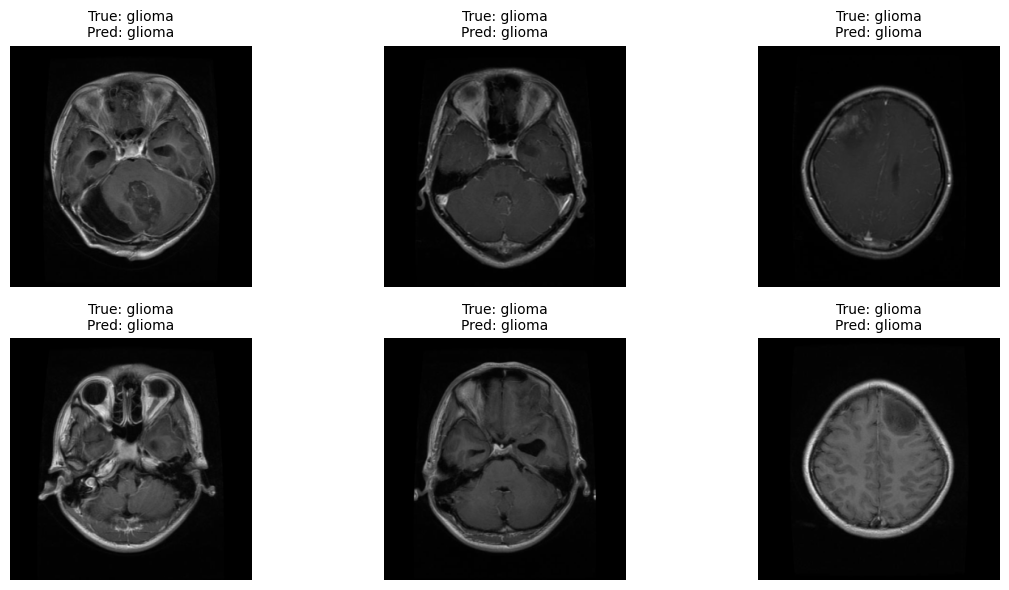

In [35]:
# First test
model2.load_state_dict(torch.load("best_brain_tumor_ InceptionV3.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Initial InceptionV3 Model
              precision    recall  f1-score   support

      glioma       0.96      0.85      0.90       300
  meningioma       0.84      0.85      0.85       306
     notumor       0.95      1.00      0.97       405
   pituitary       0.94      0.97      0.95       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



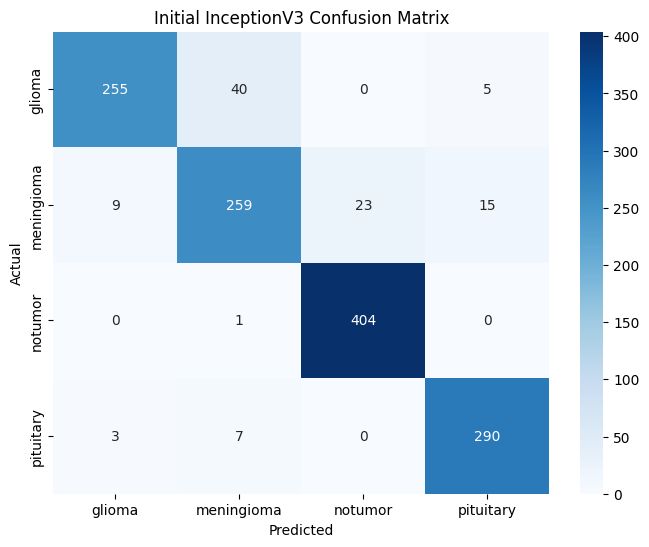

In [36]:
print("\nEvaluation: Initial InceptionV3 Model")
model2.load_state_dict(torch.load("best_brain_tumor_ InceptionV3.pth"))
evaluate_model(model2, test_loader, class_names, title="Initial InceptionV3 Confusion Matrix")


In [37]:
# Fine-tuning
for name, param in model2.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='InceptionV3_finetuned')

Epoch [1/60] Train Loss: 0.2435, Train Acc: 0.9044 Val Loss: 0.2008, Val Acc: 0.9276
Epoch [2/60] Train Loss: 0.2148, Train Acc: 0.9158 Val Loss: 0.2014, Val Acc: 0.9311
No improvement in validation loss for 1 epoch(s).
Epoch [3/60] Train Loss: 0.2197, Train Acc: 0.9152 Val Loss: 0.2068, Val Acc: 0.9264
No improvement in validation loss for 2 epoch(s).
Epoch [4/60] Train Loss: 0.2273, Train Acc: 0.9106 Val Loss: 0.2028, Val Acc: 0.9322
No improvement in validation loss for 3 epoch(s).
Epoch [5/60] Train Loss: 0.2095, Train Acc: 0.9220 Val Loss: 0.2017, Val Acc: 0.9264
No improvement in validation loss for 4 epoch(s).
Epoch [6/60] Train Loss: 0.2130, Train Acc: 0.9207 Val Loss: 0.2019, Val Acc: 0.9276
No improvement in validation loss for 5 epoch(s).
Early stopping triggered.


Test Accuracy: 0.9268


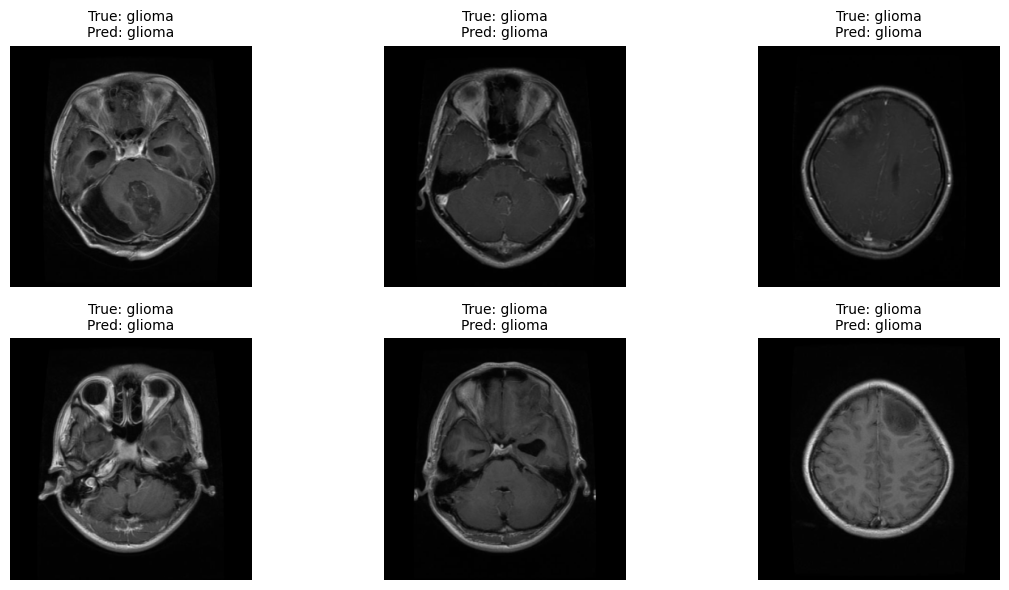

In [38]:
# Final test
model2.load_state_dict(torch.load("best_brain_tumor_InceptionV3_finetuned.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Fine-tuned InceptionV3 Model
              precision    recall  f1-score   support

      glioma       0.97      0.83      0.89       300
  meningioma       0.84      0.88      0.86       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.93      0.98      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



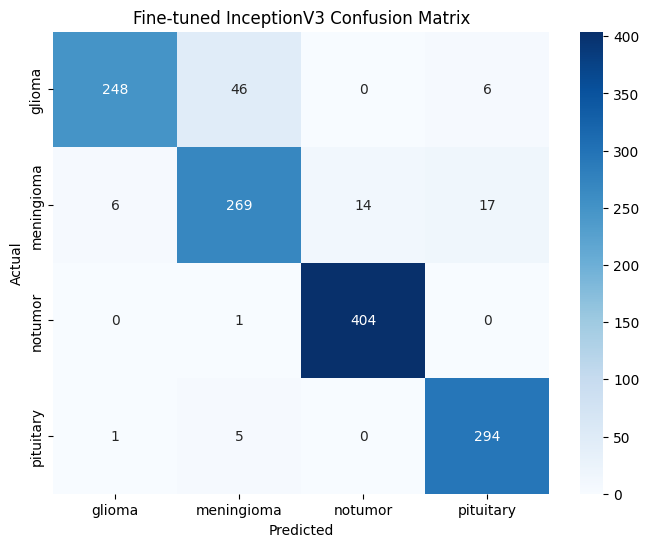

In [40]:
print("\nEvaluation: Fine-tuned InceptionV3 Model")
model2.load_state_dict(torch.load("best_brain_tumor_InceptionV3_finetuned.pth"))
evaluate_model(model2, test_loader, class_names, title="Fine-tuned InceptionV3 Confusion Matrix")
